# Data augmentation for time-series data

#### This is a simple example to apply data augmentation to time-series data (e.g. wearable sensor data). If it helps your research, please cite the below paper. 

T. T. Um et al., “Data augmentation of wearable sensor data for parkinson’s disease monitoring using convolutional neural networks,” in Proceedings of the 19th ACM International Conference on Multimodal Interaction, ser. ICMI 2017. New York, NY, USA: ACM, 2017, pp. 216–220. 

https://dl.acm.org/citation.cfm?id=3136817

https://arxiv.org/abs/1706.00527

@inproceedings{TerryUm_ICMI2017,
 author = {Um, Terry T. and Pfister, Franz M. J. and Pichler, Daniel and Endo, Satoshi and Lang, Muriel and Hirche, Sandra and Fietzek, Urban and Kuli\'{c}, Dana},
 title = {Data Augmentation of Wearable Sensor Data for Parkinson's Disease Monitoring Using Convolutional Neural Networks},
 booktitle = {Proceedings of the 19th ACM International Conference on Multimodal Interaction},
 series = {ICMI 2017},
 year = {2017},
 isbn = {978-1-4503-5543-8},
 location = {Glasgow, UK},
 pages = {216--220},
 numpages = {5},
 doi = {10.1145/3136755.3136817},
 acmid = {3136817},
 publisher = {ACM},
 address = {New York, NY, USA},
 keywords = {Parkinson\&\#39;s disease, convolutional neural networks, data augmentation, health monitoring, motor state detection, wearable sensor},
} 

#### You can freely modify this code for your own purpose. However, please leave the above citation information untouched when you redistributed the code to others. Please contact me via email if you have any questions. Your contributions on the code are always welcome. Thank you.

Terry Taewoong Um (terry.t.um@gmail.com)

https://twitter.com/TerryUm_ML

https://github.com/terryum/Data-Augmentation-For-Wearable-Sensor-Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation

(3600, 3)


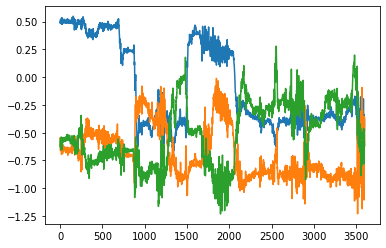

In [11]:
myX = np.load('X_sample.npy')
print(myX.shape)  ## 3600 samples (Time) * 3 features (X,Y,Z)

Make sure that your data are asssume to have (time*feat) dimension.

[0, 3600, -1.5, 1.5]

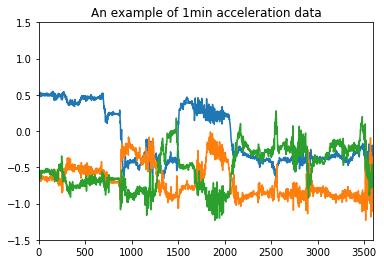

In [4]:
plt.plot(myX)
plt.title("An example of 1min acceleration data")
plt.axis([0,3600,-1.5,1.5])

## 1. Jittering

#### Hyperparameters :  sigma = standard devitation (STD) of the noise

In [5]:
sigma = 0.05

In [6]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

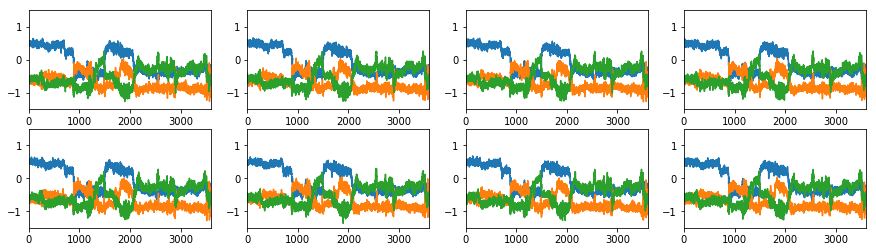

In [7]:
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_Jitter(myX, sigma))
    ax.set_xlim([0,3600])
    ax.set_ylim([-1.5,1.5])

## 2. Scaling
缩放在这里指代的是序列的高低值，比如序列值从1变成了1.2，从1变成了0.9等，对整个序列进行一定比例的缩放

#### Hyperparameters :  sigma = STD of the zoom-in/out factor

In [14]:
sigma = 0.1

In [12]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    print(scalingFactor)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

[[0.95302317 1.15504644 1.07438647]]


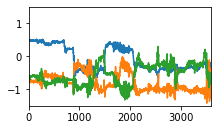

In [15]:
fig = plt.figure(figsize=(15,4))
for ii in range(1):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_Scaling(myX, sigma))
    ax.set_xlim([0,3600])
    ax.set_ylim([-1.5,1.5])

## 3. Magnitude Warping

#### Hyperparameters :  sigma = STD of the random knots for generating curves

#### knot = # of knots for the random curves (complexity of the curves)

"Scaling" can be considered as "applying constant noise to the entire samples" whereas "Jittering" can be considered as "applying different noise to each sample". 

"Magnitude Warping" can be considered as "applying smoothly-varing noise to the entire samples"
可以将Mag Warping是将平滑变化的噪声应用于整体，从实验来看效果不是很好，和单独用缩放效果差不多，可以理解为每处的缩放不是固定值了


In [16]:
sigma = 0.2
knot = 4

In [17]:
## This example using cubic splice is not the best approach to generate random curves. 
## You can use other aprroaches, e.g., Gaussian process regression, Bezier curve, etc.
def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    cs_y = CubicSpline(xx[:,1], yy[:,1])
    cs_z = CubicSpline(xx[:,2], yy[:,2])
    return np.array([cs_x(x_range),cs_y(x_range),cs_z(x_range)]).transpose()

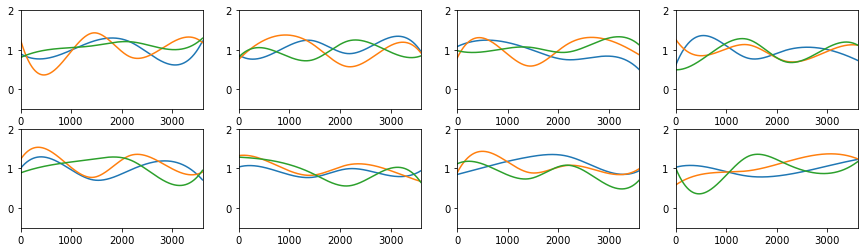

In [19]:
## Random curves around 1.0
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(GenerateRandomCurves(myX, sigma))
    plt.axis([0,3600,-0.5,2])

In [14]:
def DA_MagWarp(X, sigma):
    return X * GenerateRandomCurves(X, sigma)

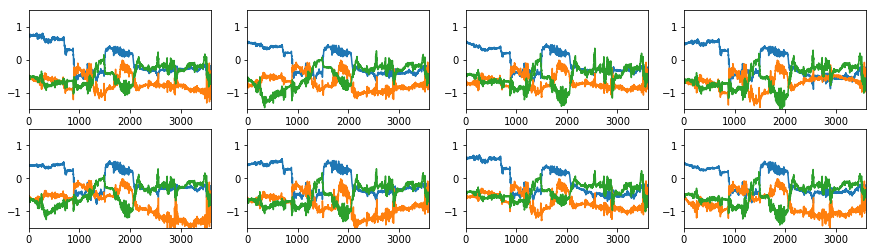

In [15]:
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_MagWarp(myX, sigma))
    ax.set_xlim([0,3600])
    ax.set_ylim([-1.5,1.5])

## 4. Time Warping
Time Warping的提升比较大，进行时间间隔的扭曲，比如0~1完成的，可以扭曲为0~2完成的
我感觉可以理解为手动横向进行拉伸，比如原来[1,1]的点移动到了[0.9,1]处

#### Hyperparameters :  sigma = STD of the random knots for generating curves

#### knot = # of knots for the random curves (complexity of the curves)

In [29]:
sigma = 0.2
knot = 4

In [30]:
def DistortTimesteps(X, sigma=0.2):
    # tt对应MagWrap中的扭曲曲线
    tt = GenerateRandomCurves(X, sigma) # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)        # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    t_scale = [(X.shape[0]-1)/tt_cum[-1,0],(X.shape[0]-1)/tt_cum[-1,1],(X.shape[0]-1)/tt_cum[-1,2]]
    tt_cum[:,0] = tt_cum[:,0]*t_scale[0]
    tt_cum[:,1] = tt_cum[:,1]*t_scale[1]
    tt_cum[:,2] = tt_cum[:,2]*t_scale[2]
    return tt_cum

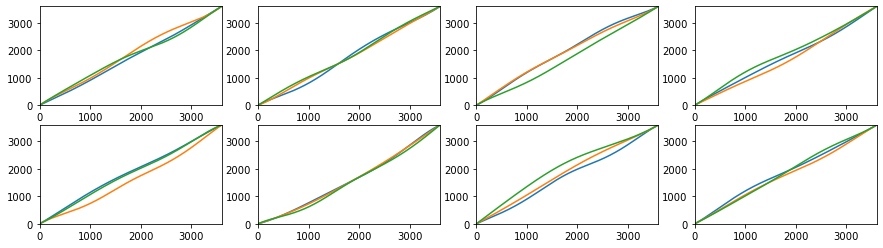

In [31]:
## Random curves around 1.0
fig = plt.figure(figsize=(15,4))
for ii in range(1):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DistortTimesteps(myX, sigma))
    ax.set_xlim([0,3600])
    ax.set_ylim([0,3600])

In [35]:
def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    print(tt_new)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    # 一维插值 参数分别表示:待插入数据的横坐标，原始数据的横坐标，原始数据的纵坐标
    X_new[:,0] = np.interp(x_range, tt_new[:,0], X[:,0])
    X_new[:,1] = np.interp(x_range, tt_new[:,1], X[:,1])
    X_new[:,2] = np.interp(x_range, tt_new[:,2], X[:,2])
    return X_new

[[8.05004242e-01 9.25949945e-01 8.57584089e-01]
 [1.61146460e+00 1.85177536e+00 1.71609564e+00]
 [2.41937685e+00 2.77747713e+00 2.57553286e+00]
 ...
 [3.59671258e+03 3.59752288e+03 3.59674310e+03]
 [3.59785566e+03 3.59826212e+03 3.59787125e+03]
 [3.59900000e+03 3.59900000e+03 3.59900000e+03]]


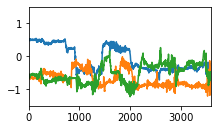

In [36]:
fig = plt.figure(figsize=(15,4))
for ii in range(1):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_TimeWarp(myX, sigma))
    ax.set_xlim([0,3600])
    ax.set_ylim([-1.5,1.5])

## 5. Rotation
简单的进行旋转

#### Hyperparameters :  N/A

In [21]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

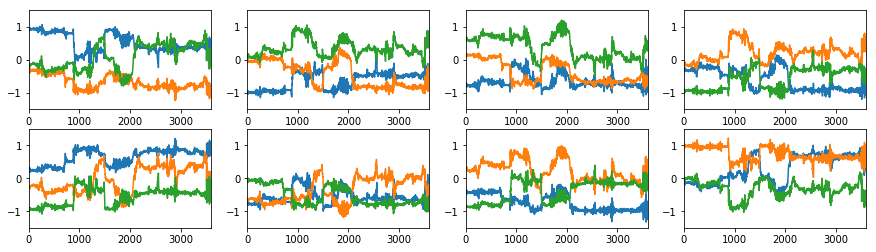

In [22]:
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_Rotation(myX))
    ax.set_xlim([0,3600])
    ax.set_ylim([-1.5,1.5])

## 6. Permutation

#### Hyperparameters :  nPerm = # of segments to permute
#### minSegLength = allowable minimum length for each segment

In [23]:
nPerm = 4 # 切成4段
minSegLength = 100

In [24]:
def DA_Permutation(X, nPerm=4, minSegLength=10):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile == True:
        segs = np.zeros(nPerm+1, dtype=int)
        segs[1:-1] = np.sort(np.random.randint(minSegLength, X.shape[0]-minSegLength, nPerm-1))
        segs[-1] = X.shape[0]
        if np.min(segs[1:]-segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]]:segs[idx[ii]+1],:]
        X_new[pp:pp+len(x_temp),:] = x_temp
        pp += len(x_temp)
    return(X_new)

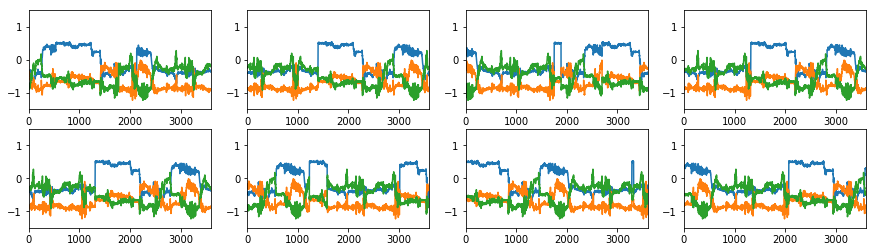

In [25]:
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_Permutation(myX))
    ax.set_xlim([0,3600])
    ax.set_ylim([-1.5,1.5])

## 7. Random Sampling

#### Hyperparameters :  nSample = # of subsamples (nSample <= X.shape[0])

This approach is similar to TimeWarp, but will use only subsamples (not all samples) for interpolation. (Using TimeWarp is more recommended)
相当于这个随机采样是对部分的序列插值，而Time Wraping是对整个序列进行拟合。
假设我有3000个点，我选择了1000个点，然后通过这1000个点的值进行线性插值，最终插值回3000个点

In [26]:
nSample = 1000

In [20]:
# 随机在原始数据中选择了nSample个点
def RandSampleTimesteps(X, nSample=1000):
    X_new = np.zeros(X.shape)
    tt = np.zeros((nSample,X.shape[1]), dtype=int)
    tt[1:-1,0] = np.sort(np.random.randint(1,X.shape[0]-1,nSample-2))
    tt[1:-1,1] = np.sort(np.random.randint(1,X.shape[0]-1,nSample-2))
    tt[1:-1,2] = np.sort(np.random.randint(1,X.shape[0]-1,nSample-2))
    tt[-1,:] = X.shape[0]-1
    return tt

In [27]:
def DA_RandSampling(X, nSample=1000):
    tt = RandSampleTimesteps(X, nSample)
    X_new = np.zeros(X.shape)
    X_new[:,0] = np.interp(np.arange(X.shape[0]), tt[:,0], X[tt[:,0],0])
    X_new[:,1] = np.interp(np.arange(X.shape[0]), tt[:,1], X[tt[:,1],1])
    X_new[:,2] = np.interp(np.arange(X.shape[0]), tt[:,2], X[tt[:,2],2])
    return X_new

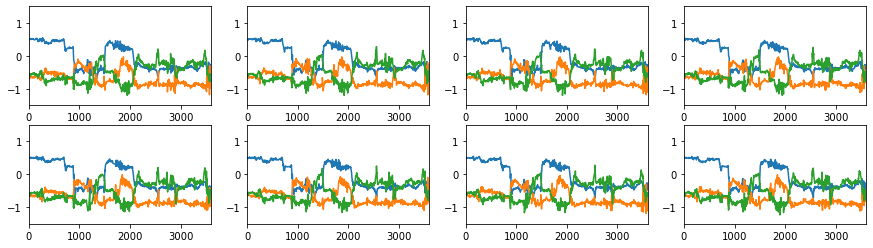

In [28]:
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_RandSampling(myX))
    ax.set_xlim([0,3600])
    ax.set_ylim([-1.5,1.5])

## 8. Combinations

You can combine any of the above data augmentation techiniques. For example, 

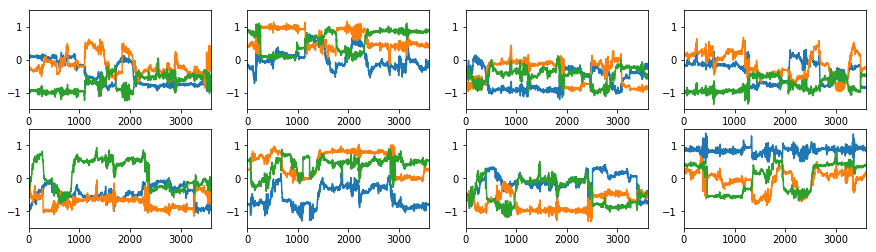

In [30]:
## Rotation + Permutation
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_Rotation(DA_Permutation(myX, nPerm=4)))
    ax.set_xlim([0,3600])
    ax.set_ylim([-1.5,1.5])